In [6]:
import datajoint as dj
import numpy as np
import pandas as pd
from pipeline.ingest import behavior
from pipeline import lab, get_schema_name, experiment, foraging_analysis
import pipeline.shell as shell
[hh for hh in dj.list_schemas() if 'hanhou' in hh]

['hanhou_foraging_ccf',
 'hanhou_foraging_experiment',
 'hanhou_foraging_foraging_analysis',
 'hanhou_foraging_ingest_behavior',
 'hanhou_foraging_lab',
 'hanhou_test']

# Show schema

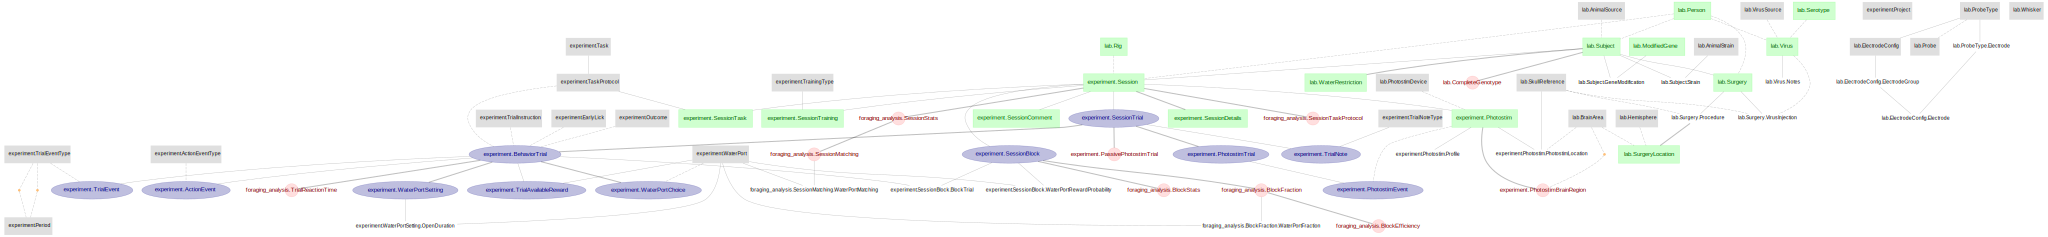

In [7]:
dj.ERD(foraging_analysis) + dj.ERD(lab) + dj.ERD(experiment) 

In [4]:
lab.WaterRestriction()

subject_id institution 6 digit animal ID,water_restriction_number WR number,cage_number,wr_start_date,wr_start_weight
447921,HC16,169209,2019-09-11,20.900
452271,FOR18,176572,2020-01-13,28.000
452272,FOR12,173028,2019-09-16,30.200
452273,FOR15,175553,2019-12-09,30.100
452274,FOR17,176432,2020-01-09,30.000
452275,FOR11,173025,2019-09-16,28.200
453475,FOR02,170095,2019-06-18,20.600
453476,FOR04,170100,2019-06-18,21.300
453477,FOR03,170096,2019-06-18,18.400
453478,FOR01,170093,2019-06-18,18.900


## Ingest meta data

In [5]:
shell.load_meta_foraging()

Adding experimenters...
  duplicate. experimenter:  rozsam  already exists
  duplicate. experimenter:  Tina  already exists
  duplicate. experimenter:  NT  already exists
  duplicate. experimenter:  singha  already exists
  duplicate. experimenter:  liangy10  already exists
  duplicate. experimenter:  HH  already exists
Adding rigs... 
  duplicate. rig:  Training-Tower-1  already exists
  duplicate. rig:  Training-Tower-2  already exists
  duplicate. rig:  Training-Tower-3  already exists
  duplicate. rig:  Voltage-Imaging-1p  already exists
  duplicate. rig:  virtual_setup  already exists
  duplicate. rig:  Genie-2p-Resonant-MIMMS  already exists
Adding subjects and water restrictions...
  duplicate. animal : 453478  already exists
  duplicate. water restriction: FOR01  already exists
  duplicate. animal : 453475  already exists
  duplicate. water restriction: FOR02  already exists
  duplicate. animal : 453477  already exists
  duplicate. water restriction: FOR03  already exists
  dup

In [7]:
(lab.WaterRestriction() * lab.Subject.proj(cage_number_subject="cage_number")).fetch(format='frame').sort_values(by='water_restriction_number')

,water_restriction_number,cage_number,wr_start_date,wr_start_weight,cage_number_subject
subject_id,,,,,
453478,FOR01,170093,2019-06-18,18.900,170093
453475,FOR02,170095,2019-06-18,20.600,170095
453477,FOR03,170096,2019-06-18,18.400,170096
453476,FOR04,170100,2019-06-18,21.300,170100
455525,FOR05,171953,2019-08-12,23.700,171953
455526,FOR06,171799,2019-08-08,23.300,171799
457494,FOR07,172378,2019-08-26,26.000,172378
457495,FOR08,172377,2019-08-26,20.400,172377
457496,FOR09,172580,2019-09-03,21.900,172580


In [9]:
experiment.SessionComment()

subject_id institution 6 digit animal ID,session session number,session_comment
447921,1,nan
447921,2,100% vs 0%
447921,3,"100% vs 0, 90 Vs10"
447921,4,introduce early-lick punishment
447921,5,"difficulty 2 => 3, total reward:1 => 0.8 => 0.6 => 0.5"
447921,6,nan
447921,7,nan
447921,8,"total reward: 0.5 => 0.45, delay: 1s => 2 s"
447921,9,difficulty: 4; lickport too low
447921,10,nan


## Ingest foraging sessions

In [ ]:
shell.ingest_foraging_behavior()

In [15]:
behavior.BehaviorBpodIngest()

subject_id institution 6 digit animal ID,session session number
447921,1
447921,2


In [2]:
experiment.Session()

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig
447921,1,2019-09-11,13:56:46,NT,Training-Tower-3
447921,2,2019-09-12,21:25:47,NT,Training-Tower-3
447921,3,2019-09-13,15:52:49,NT,Training-Tower-3
447921,4,2019-09-14,15:32:03,NT,Training-Tower-3


# Query testing

In [31]:
lab.Subject().

['subject_id']

In [22]:
lab.WaterRestriction().fetch()

array([(447921, 'HC16', 169209, datetime.date(2019, 9, 11), Decimal('20.900')),
       (452271, 'FOR18', 176572, datetime.date(2020, 1, 13), Decimal('28.000')),
       (452272, 'FOR12', 173028, datetime.date(2019, 9, 16), Decimal('30.200')),
       (452273, 'FOR15', 175553, datetime.date(2019, 12, 9), Decimal('30.100')),
       (452274, 'FOR17', 176432, datetime.date(2020, 1, 9), Decimal('30.000')),
       (452275, 'FOR11', 173025, datetime.date(2019, 9, 16), Decimal('28.200')),
       (453475, 'FOR02', 170095, datetime.date(2019, 6, 18), Decimal('20.600')),
       (453476, 'FOR04', 170100, datetime.date(2019, 6, 18), Decimal('21.300')),
       (453477, 'FOR03', 170096, datetime.date(2019, 6, 18), Decimal('18.400')),
       (453478, 'FOR01', 170093, datetime.date(2019, 6, 18), Decimal('18.900')),
       (455525, 'FOR05', 171953, datetime.date(2019, 8, 12), Decimal('23.700')),
       (455526, 'FOR06', 171799, datetime.date(2019, 8, 8), Decimal('23.300')),
       (457494, 'FOR07', 172378

In [21]:
lab.WaterRestriction & behavior.BehaviorBpodIngest()

subject_id institution 6 digit animal ID,water_restriction_number WR number,cage_number,wr_start_date,wr_start_weight
447921,HC16,169209,2019-09-11,20.900
452271,FOR18,176572,2020-01-13,28.000
452272,FOR12,173028,2019-09-16,30.200
452273,FOR15,175553,2019-12-09,30.100
452274,FOR17,176432,2020-01-09,30.000
452275,FOR11,173025,2019-09-16,28.200
453475,FOR02,170095,2019-06-18,20.600
453476,FOR04,170100,2019-06-18,21.300
453477,FOR03,170096,2019-06-18,18.400
453478,FOR01,170093,2019-06-18,18.900


In [20]:
(experiment.Session  * experiment.SessionComment * experiment.SessionDetails & 'subject_id = 455525').fetch()[-1]

(455525, 53, 'nan', datetime.date(2019, 11, 4), datetime.timedelta(seconds=70773), 'Tina', 'Training-Tower-2', Decimal('17.8000'), Decimal('0.4000'), Decimal('0.6000'))

In [19]:
experiment.TaskProtocol()

task task type,task_protocol task protocol,task_protocol_description
audio delay,1,high tone vs. low tone
foraging,100,"moving lickports, delay period, early lick punishment, sound GO cue then free choice"
foraging 3lp,101,"moving lickports, delay period, early lick punishment, sound GO cue then free choice from three lickports"
s1 stim,2,mini-distractors
s1 stim,3,"full distractors, with 2 distractors (at different times) on some of the left trials"
s1 stim,4,full distractors
s1 stim,5,"mini-distractors, with different levels of the mini-stim during sample period"
s1 stim,6,full distractors; same as protocol 4 but with a no-chirp trial-type
s1 stim,7,mini-distractors and full distractors (only at late delay)
s1 stim,8,"mini-distractors and full distractors (only at late delay), with different levels of the mini-stim and the full-stim during sample period"


In [19]:
experiment.SessionComment()

subject_id institution 6 digit animal ID,session session number,session_comment
447921,1,nan
447921,2,100% vs 0%
447921,3,"100% vs 0, 90 Vs10"
447921,4,introduce early-lick punishment
447921,5,"difficulty 2 => 3, total reward:1 => 0.8 => 0.6 => 0.5"
447921,6,nan
447921,7,nan
447921,8,"total reward: 0.5 => 0.45, delay: 1s => 2 s"
447921,9,difficulty: 4; lickport too low
447921,10,nan


In [18]:
experiment.SessionTask()

AttributeError: module 'pipeline.experiment' has no attribute 'SessionTask'

In [17]:
(lab.WaterRestriction() & (experiment.BehaviorTrial() & 'task in ("foraging", "foraging 3lp")')).fetch(format='frame').sort_values(by='water_restriction_number')

,water_restriction_number,cage_number,wr_start_date,wr_start_weight
subject_id,,,,
453478,FOR01,170093,2019-06-18,18.900
453475,FOR02,170095,2019-06-18,20.600
453477,FOR03,170096,2019-06-18,18.400
453476,FOR04,170100,2019-06-18,21.300
455525,FOR05,171953,2019-08-12,23.700
455526,FOR06,171799,2019-08-08,23.300
457494,FOR07,172378,2019-08-26,26.000
457495,FOR08,172377,2019-08-26,20.400
457496,FOR09,172580,2019-09-03,21.900


Number of foraging sessions for each mice

In [23]:
foraging_sessions = (lab.WaterRestriction() * experiment.Session & 
                    (experiment.BehaviorTrial & 'task in ("foraging", "foraging 3lp")'))\
                    .fetch(format='frame')
foraging_sessions.groupby(['water_restriction_number']).size()

water_restriction_number
FOR01     27
FOR02     28
FOR03     29
FOR04     28
FOR05     53
FOR06     55
FOR07     39
FOR08     40
FOR09    144
FOR10    141
FOR11     65
FOR12     63
FOR13     13
FOR14     10
FOR15     65
FOR16      3
FOR17     45
FOR18     46
FOR19     42
FOR20     48
HC16      38
HC37      48
HC38      48
HH01      26
HH04      16
dtype: int64

In [16]:
(experiment.Session() & (lab.WaterRestriction() & 'water_restriction_number="HH01"')).fetch(format='frame')

session_date    session_time username               rig
subject_id session                                                        
472195     1         2020-07-29 0 days 15:48:11       HH  Training-Tower-2
           2         2020-07-30 0 days 20:21:25       HH  Training-Tower-2
           3         2020-07-31 0 days 19:44:40       HH  Training-Tower-2
           4         2020-08-01 0 days 20:54:52       HH  Training-Tower-2
           5         2020-08-02 0 days 16:34:26       HH  Training-Tower-2
           6         2020-08-03 0 days 16:57:31       HH  Training-Tower-2
           7         2020-08-04 0 days 17:34:40       HH  Training-Tower-2
           8         2020-08-05 0 days 17:19:57       HH  Training-Tower-2
           9         2020-08-09 0 days 19:51:56       HH  Training-Tower-2
           10        2020-08-10 0 days 20:38:34       HH  Training-Tower-2
           11        2020-08-11 0 days 20:10:35       HH  Training-Tower-2
           12        2020-08-12 0 days 20:33:32       HH  Training-Tower-2
           13        2020-08-13 0 days 19:59:03       HH  Training-Tower-2
           14        2020-08-15 0 days 20:08:40       HH  Training-Tower-2
           15        2020-08-16 0 days 20:55:27       HH  Training-Tower-2
           16        2020-08-17 0 days 18:35:39       HH  Training-Tower-2
           17        2020-08-19 0 days 16:55:26       HH  Training-Tower-2
           18        2020-08-21 0 days 20:05:10       HH  Training-Tower-2
           19        2020-08-22 0 days 20:54:30       HH  Training-Tower-2
           20        2020-08-23 0 days 20:13:12       HH  Training-Tower-2
           21        2020-08-24 0 days 20:36:27       HH  Training-Tower-2
           22        2020-08-25 0 days 21:05:10       HH  Training-Tower-2
           23        2020-08-26 0 days 21:36:37       HH  Training-Tower-2
           24        2020-08-27 0 days 20:39:47       HH  Training-Tower-2
           25        2020-08-28 0 days 20:06:38       HH  Training-Tower-2
           26        2020-08-29 0 days 20:08:54       HH  Training-Tower-2

In [24]:
HC16_sessions = experiment.Session() & (lab.WaterRestriction() & 'water_restriction_number="HC16"')

LostConnectionError: ('Connection timed out', "MySQL server has gone away (ConnectionAbortedError(10053, 'An established connection was aborted by the software in your host machine', None, 10053, None))")

In [5]:
HC16_sessions

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig
447921,1,2019-09-11,13:56:46,NT,Training-Tower-3
447921,2,2019-09-12,21:25:47,NT,Training-Tower-3
447921,3,2019-09-13,15:52:49,NT,Training-Tower-3
447921,4,2019-09-14,15:32:03,NT,Training-Tower-3


In [9]:
temp_session = (experiment.BehaviorTrial() * experiment.WaterPortChoice() & HC16_sessions & 'session=2')
temp_session.fetch(format='frame')

task  task_protocol trial_instruction  \
subject_id session trial                                              
447921     2       1      foraging            100              none   
                   2      foraging            100              none   
                   3      foraging            100              none   
                   4      foraging            100              none   
                   5      foraging            100              none   
...                            ...            ...               ...   
                   583    foraging            100              none   
                   584    foraging            100              none   
                   585    foraging            100              none   
                   586    foraging            100              none   
                   587    foraging            100              none   

                         early_lick outcome  auto_water  free_water water_port  
subject_id session trial                                                        
447921     2       1       no early  ignore           0           0       None  
                   2       no early  ignore           0           0       None  
                   3       no early  ignore           0           0       None  
                   4       no early     hit           0           0      right  
                   5       no early  ignore           0           0       None  
...                             ...     ...         ...         ...        ...  
                   583        early     hit           0           0      right  
                   584        early     hit           0           0      right  
                   585     no early     hit           0           0      right  
                   586        early     hit           0           0      right  
                   587        early     hit           0           0      right  

[587 rows x 8 columns]

Check block info

In [7]:
(experiment.SessionBlock & temp_session).WaterPortRewardProbability() * ((experiment.SessionBlock & temp_session).BlockTrial())

subject_id institution 6 digit animal ID,session session number,block block number,"water_port e.g. left, right, middle, top-left, purple",trial trial number (1-based indexing),reward_probability
447921,1,1,left,1,0.0000
447921,1,1,left,2,0.0000
447921,1,1,right,1,1.0000
447921,1,1,right,2,1.0000
447921,1,2,left,3,0.0000
447921,1,2,left,4,0.0000
447921,1,2,left,5,0.0000
447921,1,2,left,6,0.0000
447921,1,2,left,7,0.0000
447921,1,2,right,3,1.0000


In [12]:
temp_session.fetch(format='frame')[['water_port', 'outcome']].drop_duplicates()

water_port outcome
subject_id session trial                   
447921     2       1           None  ignore
                   4          right     hit
                   8          right    miss
                   9           left     hit
                   16          left    miss

In [13]:
temp_session.fetch(format='frame')['outcome'].value_counts()

hit       311
miss      271
ignore      5
Name: outcome, dtype: int64

# Populate Behavior_foraging for inspector

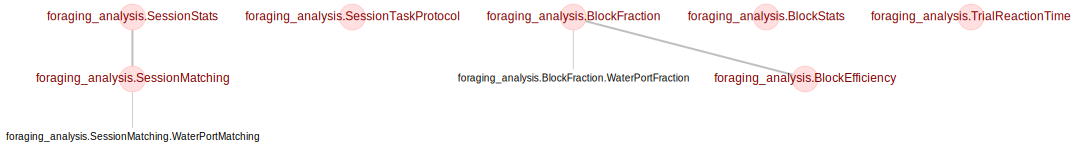

In [8]:
dj.ERD(foraging_analysis)

In [ ]:
foraging_analysis.TrialReactionTime.populate(display_progress=True, reserve_jobs=False)

In [ ]:
foraging_analysis.BlockStats.populate(display_progress=True, reserve_jobs=False)

  3%|████████▊                                                                                                                                                                                                                                                                          | 821/25646 [00:38<19:28, 21.24it/s]

In [3]:
foraging_analysis.SessionStats.populate(display_progress=True, reserve_jobs=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:55<00:00,  8.80it/s]


In [5]:
foraging_analysis.SessionTaskProtocol.populate(display_progress=True, reserve_jobs=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1160/1160 [00:59<00:00, 19.50it/s]


In [ ]:
foraging_analysis.BlockFraction.populate(display_progress=True, reserve_jobs=False)

In [ ]:
behavior_foraging.SessionMatching.populate(display_progress=True, reserve_jobs=False)

 20%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                             | 230/1160 [00:19<01:17, 12.04it/s]

In [ ]:
foraging_analysis.BlockEfficiency.populate(display_progress=True, reserve_jobs=False)

  1%|███▋                                                                                                                                                                                                                                                                               | 350/25818 [00:06<19:12, 22.10it/s]

In [90]:
schema = dj.schema(get_schema_name('foraging_analysis'),locals())
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__trial_reaction_time,31e53c14630a721dbe5e9c540f332698,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,52304,16221,2020-09-09 00:17:03
__trial_reaction_time,4ddfcfce8a9cd83a9bc607cc684bf1d3,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,50236,16227,2020-09-09 00:17:03
__trial_reaction_time,89a2a4906c28cee407395c33b312831c,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,22924,16235,2020-09-09 00:17:03
__trial_reaction_time,8d5ff79bf74f0cded18897ba64da39cf,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,23036,16233,2020-09-09 00:17:03
__trial_reaction_time,a41eee98ae7eb7c2db02605466bce26d,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,39872,16222,2020-09-09 00:17:03
__trial_reaction_time,c8d7c417ef47c1059ebf61e4e47eaad4,reserved,=BLOB=,,=BLOB=,hanhou@206.241.1.246,houh-ww1,54388,16223,2020-09-09 00:17:03


In [62]:
schema.jobs.delete() 

In [408]:
dj.kill()

  ID USER         HOST          STATE         TIME    INFO
+--+ +----------+ +-----------+ +-----------+ +-----+
16087 hanhou       206.241.1.246:31558                 1633  None
16088 hanhou       206.241.1.246:12160 query end          0  INSERT INTO `hanhou_foraging_behavior_foraging`.`~jobs`(`table_name`,`key_hash`,`status`,`key`,`user`,`host`,`pid`,`connection_id`) VALUES ('__trial_reaction_time','3a04bcb32a48477ef75511110c4d43ed','reserved','dj0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\n\0\0\0\0\0\0\0subject_id\0\0\0\0\0\0\0\n\0?\0\0\0\0\0\0\0\0\0\0\0\0\0\0session\0\0\0\0\0\0\0\n\0t\0\0\0\0\0\0\0\0\0\0\0\0\0\0trial\0\0\0\0\0\0\0\n\00','hanhou@206.241.1.246','houh-ww1','47064','16088')
16089 hanhou       206.241.1.246:59966 query end          0  INSERT INTO `hanhou_foraging_behavior_foraging`.`~jobs`(`table_name`,`key_hash`,`status`,`key`,`user`,`host`,`pid`,`connection_id`) VALUES ('__trial_reaction_time','511de696536c283b5111d23248575bcd','reserved','dj0\0\0\0\0\0\0\0\0

process to kill or "q" to quit > q


In [97]:
len(foraging_analysis.TrialReactionTime())

650814

In [77]:
foraging_analysis.TrialReactionTime().drop()

`hanhou_foraging_behavior_foraging`.`__trial_reaction_time` (46312 tuples)
Proceed? [yes, No]: no


In [26]:
len(experiment.BehaviorTrial())

650814

In [112]:
len(foraging_analysis.BlockEfficiency())

6180

In [31]:
len(experiment.SessionBlock())

25818

In [122]:
len(foraging_analysis.BlockFraction())

6180

In [123]:
len(foraging_analysis.SessionStats())

LostConnectionError: ('Server connection lost', 'Lost connection to MySQL server during query')

In [120]:
foraging_analysis.BlockEfficiency.ancestors()

TypeError: ancestors() missing 1 required positional argument: 'self'

# Clear all (Nuclear)

In [ ]:
schema_to_clear = ['hanhou_foraging_ingest_behavior', 'hanhou_foraging_experiment', 'hanhou_foraging_lab', 'hanhou_foraging_ccf']
for ss in schema_to_clear:
    dj.schema(ss).drop()

# Clear Behavior_foraging only

In [2]:
schema_to_clear = ['hanhou_foraging_foraging_analysis']
for ss in schema_to_clear:
    dj.schema(ss).drop()

Proceed to delete entire schema `hanhou_foraging_behavior_foraging`? [yes, No]: yes


# Drop tables on the server

In [4]:
schema = dj.schema(get_schema_name('foraging_analysis'))
schema.spawn_missing_classes()
dj.ERD(schema)

In [ ]:
SessionMatchBias.drop()

# Crap

In [2]:
schema = dj.schema('hanhou_test')

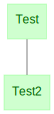

In [6]:
dj.ERD(schema)

In [5]:
@schema
class Test(dj.Manual):
    definition = """
    # Comment for table
    id: int  # id
    ---
    # this is a comment
    label = NULL: int   # Real comment  
    # another comment
    label2 = NULL: int
    """
    
@schema
class Test2(dj.Manual):
    definition = """
    # Comment for table
    id: int  # id
    -> Test
    ---
    # this is a comment
    label = NULL: int   # Real comment  
    # another comment
    label2 = NULL: int
    """

In [13]:
Test2.drop()

`hanhou_test`.`test2` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [26]:
toinsert = dict(id=3, label2=2)
Test.insert1(toinsert)

In [27]:
dj.ERD(schema)
Test()

id id,label Real comment,label2
2,None,2
3,None,2
